Path to dataset files: /kaggle/input/electric-power-consumption-data-set


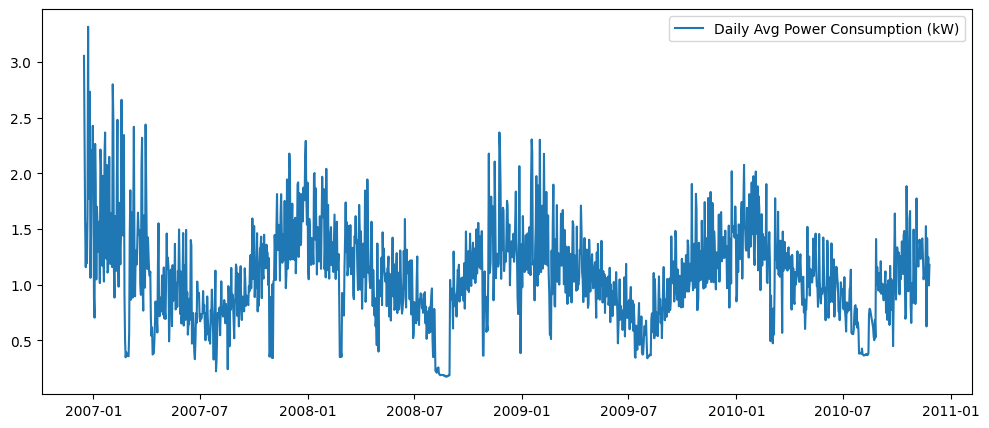

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gir302c/hjlgqf07.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2gir302c/x7mrtpgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13133', 'data', 'file=/tmp/tmp2gir302c/hjlgqf07.json', 'init=/tmp/tmp2gir302c/x7mrtpgd.json', 'output', 'file=/tmp/tmp2gir302c/prophet_modelz1v5awh_/prophet_model-20250813223108.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:31:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


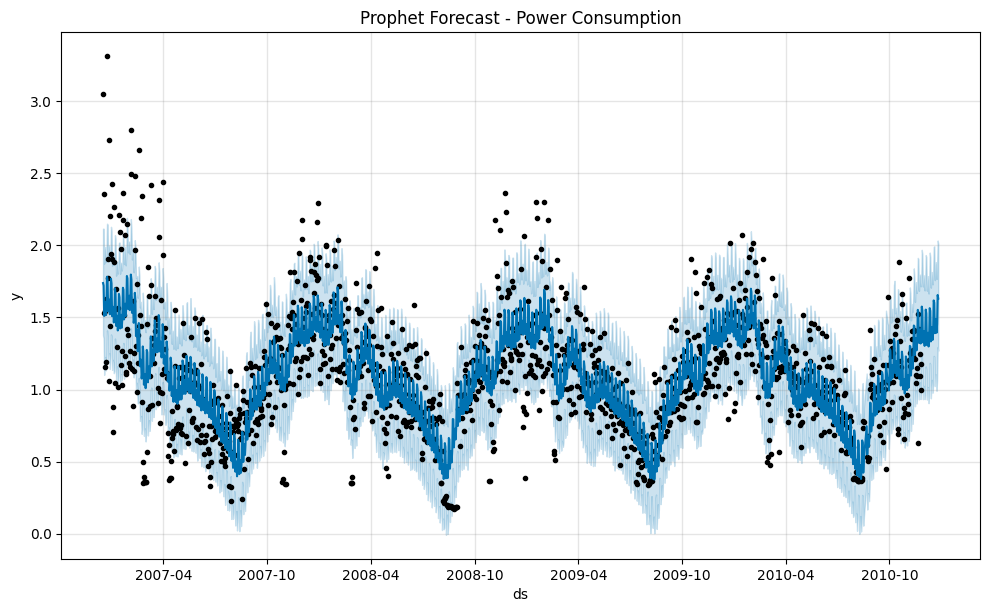

Epoch 1/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0582
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0104
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


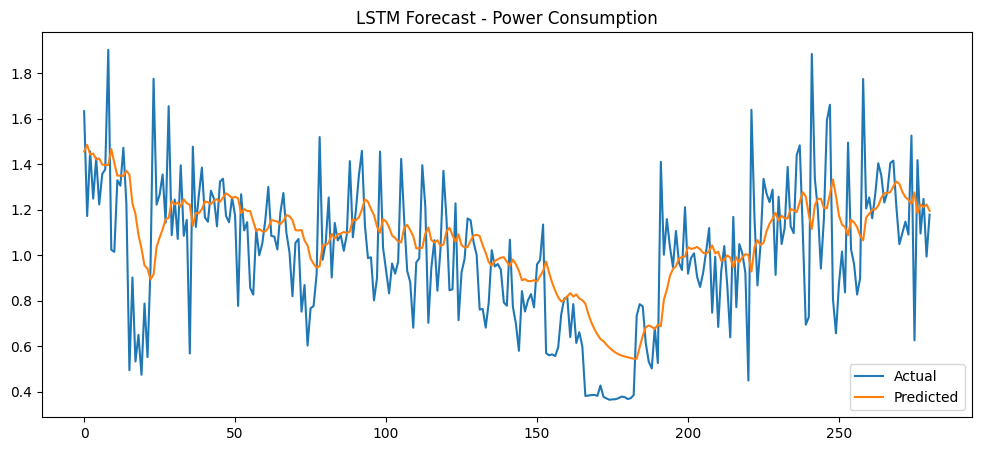

In [2]:
# ============================================================
# STEP 1: Force CPU Mode & Install Dependencies
# ============================================================
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU usage

!pip install kagglehub prophet matplotlib pandas numpy tensorflow --quiet

# ============================================================
# STEP 2: Download Dataset
# ============================================================
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
print("Path to dataset files:", path)

# Load dataset
import os
file_path = os.path.join(path, "household_power_consumption.txt")
df = pd.read_csv(file_path, sep=";", low_memory=False)

# ============================================================
# STEP 3: Data Cleaning
# ============================================================
# Replace missing values marked as "?"
df.replace("?", np.nan, inplace=True)

# Convert numeric columns
for col in df.columns[2:]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Combine Date & Time into Datetime
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

# Set Datetime as index
df.set_index("Datetime", inplace=True)
df.drop(columns=["Date", "Time"], inplace=True)

# ============================================================
# STEP 4: Resample Data (Daily Mean)
# ============================================================
daily_df = df["Global_active_power"].resample("D").mean().dropna()

plt.figure(figsize=(12, 5))
plt.plot(daily_df, label="Daily Avg Power Consumption (kW)")
plt.legend()
plt.show()

# ============================================================
# STEP 5: Prophet Forecasting
# ============================================================
from prophet import Prophet

# Prepare data
prophet_df = daily_df.reset_index()
prophet_df.columns = ["ds", "y"]

# Train model
model = Prophet()
model.fit(prophet_df)

# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Prophet Forecast - Power Consumption")
plt.show()

# ============================================================
# STEP 6: LSTM Forecasting (CPU)
# ============================================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_df.values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM Model (Lightweight for CPU)
model_lstm = Sequential([
    Input(shape=(SEQ_LEN, 1)),
    LSTM(16, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# Train
model_lstm.fit(X_train, y_train, epochs=5, batch_size=16, verbose=1)

# Predictions
y_pred = model_lstm.predict(X_test)

# Inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot results
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title("LSTM Forecast - Power Consumption")
plt.legend()
plt.show()
